# Classification by logistic regression

Parameters have been extracted from the images and are going to be implemented into a clustering algorithm.

The images were skeletonised and a voronoi diagram was made using the branch points. Then parameters from the cells in the voronoi diagram were extracted.

Nodes: number of connecting branches
Verticies: number of points
Angular defect: 
iscoperimetric: ratio proportional to the area/perimeter^2
Number of polygons:
Average number of sides per polygon:

This notebook was made following the tutorial on the tensorflow website
https://www.tensorflow.org/guide/core/logistic_regression_core

# note that validation and test have been labeled the wrong way around
I know that this is really annoying but I couldn't work out how to change it. :c

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
from sklearn.model_selection import train_test_split

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.11.0


### Prepare the data

In [24]:
# load data
data = pd.read_csv("voronoi_parameters/parameters2.txt", sep=',', header=[0])

# remove names
files = data.loc[:, "file"] 
data = data.drop("file", axis=1)

In [25]:
# change all -1 values to 0 (for normalisation)
data = data.replace(-1, 0)
#for index in range(len(data.columns)):
    #data.iloc[:, index] = data.iloc[:, index]/data.iloc[:, index].max() #normalise betwenn 0 and 1


In [26]:
conc_class = []
for index in range(len(data)):
    image = files.iloc[index]
    
    if ('OA' in image) or ('OB' in image) or ('OC' in image):
        conc_class.append("low")
    elif ('OD' in image) or ('OE' in image) or ('OF' in image):
        conc_class.append("high")
        
labeled_data = data
labeled_data["conc"] = conc_class

In [27]:
labeled_data.head()

,number of nodes,angular defect,isoperimetric ratio,average number of sides,conc
0,135,0.035832,0.607405,5.546667,low
1,5,0.000000,0.088624,3.200000,low
2,0,0.000000,0.000000,0.000000,low
3,16,0.000000,0.530207,4.545455,low
4,14,0.000000,0.516043,4.400000,low


In [28]:
train_data, test_val_data = train_test_split(labeled_data, test_size=0.4, random_state=42)
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)


#train_data.rename(index={6: "conc"})
print(train_data.columns)
print("train", len(train_data))
print("test", len(test_data))
print("val", len(val_data))
train_data.dtypes

Index([' number of nodes', ' angular defect', ' isoperimetric ratio',
       ' average number of sides', 'conc'],
      dtype='object')
train 25
test 8
val 9


 number of nodes              int64
 angular defect             float64
 isoperimetric ratio        float64
 average number of sides    float64
conc                         object
dtype: object

In [29]:
y_train = train_data["conc"]
x_train = train_data.drop("conc", axis=1) # axis=1 specifies to drop the column
y_test = test_data["conc"]
x_test = test_data.drop("conc", axis=1)
y_val = val_data["conc"]
x_val = val_data.drop("conc", axis=1)

y_train, y_test, y_val = y_train.map({'low': 0, 'high': 1}), y_test.map({'low': 0, 'high': 1}), y_val.map({'low':0, 'high':1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)
x_val, y_val = tf.convert_to_tensor(x_val, dtype=tf.float32), tf.convert_to_tensor(y_val, dtype=tf.float32)

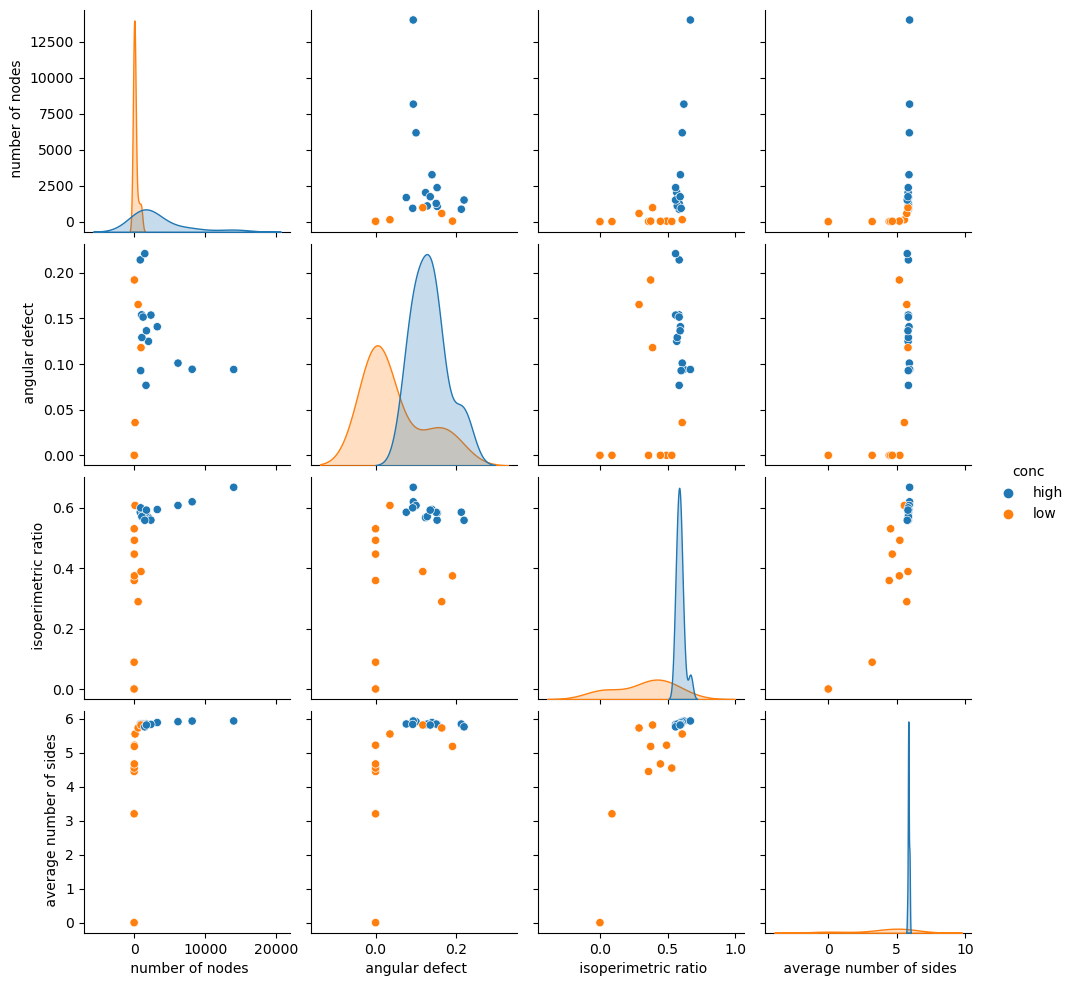

In [30]:
# iclude hue='class' not working to show different classes on the plots
sns.pairplot(train_data.iloc[:, 0:5], hue = "conc", diag_kind='kde');
plt.show()

In [31]:
train_data.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
number of nodes,25.0,1917.400000,3191.711531,0.0,37.000000,972.000000,1734.000000,14014.000000
angular defect,25.0,0.095686,0.072919,0.0,0.000000,0.100892,0.151249,0.220672
isoperimetric ratio,25.0,0.473879,0.192145,0.0,0.388616,0.567156,0.591951,0.667465
average number of sides,25.0,5.049217,1.652014,0.0,5.181818,5.811395,5.838906,5.930435


In [32]:
# make a class which allows the data to be normalised with a mean 0 and var 1
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm, x_val_norm = norm_x.norm(x_train), norm_x.norm(x_test), norm_x.norm(x_val)    
    

## Logistic regression

Maps the outputs of linear regression $(-\inf, \inf)$ to probabilities $(0, 1)$. This is symmetric so flipping the output signs form linear regression results in inverse of probability.

### Activation function

The sigmoid function will be used to determine the probability $Y = \frac{e^z}{1 + e^{-z}}$ where $z = wx +b$. 

This can be written as a matrix equation as $ Y = \sigma (wX +b)$.

Where $Y$ is the target vector (the labels).

$X$ is a matrix of features.

$w$ is a vector of weights for each feature.

$b$ is a bias.

$\sigma$ is a sigmoid function applies to each output of the matrix equation.

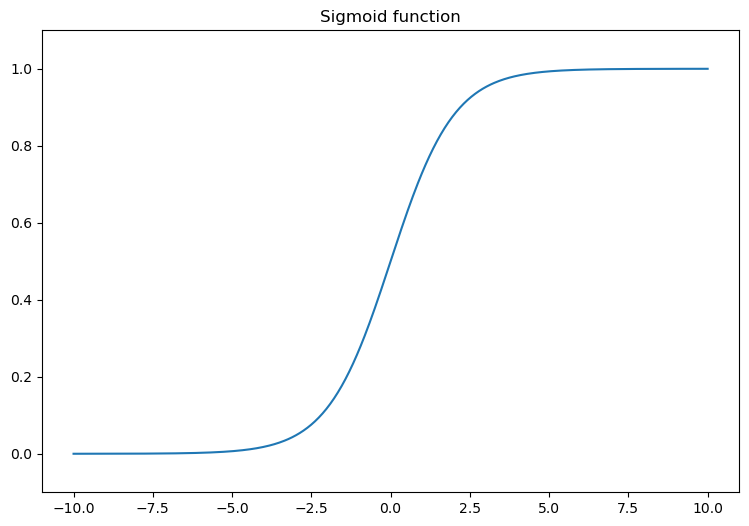

In [33]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");
plt.show()

### Loss/cost function

Use the log loss function/ binary cross-entropy loss (best loss function for binary classification with logistic regression according to tf site).

$L = -\frac{1}{m} \sum_i^m(y_i \times log(\hat{y}_i) + (1 + y_i) \times log(1-\hat{y}_i)$

Where $y_i$ is a vector of labels / targets.

$\hat{y}$ is a vector of predicted probabilities.

In [34]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

Use gradient descent to update the model in order to minimise the loss function

In [35]:
class LogisticRegression(tf.Module):
    def __init__(self):
        self.built = False
        
    def __call__(self, x, train = True):
        # initialise model params on first call
        if not self.built:
            # randomly generate weights and bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
             # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
          return z
        return tf.sigmoid(z)
                    

In [36]:
# make sure the model output values between 0 and 1 for a small subset of training data
# thich checks its working properly

log_reg = LogisticRegression()
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()


array([0.726955  , 0.69026715, 0.62486005, 0.7191642 , 0.46712863],
      dtype=float32)

In [37]:
# write an accuracy function 
def predict_class(y_pred, thresh=0.5):
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    y_pred = tf.math.sigmoid(y_pred)
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y, tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

## Train the model

In [38]:
batch_size = 10
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_norm, y_val))
val_dataset = val_dataset.shuffle(buffer_size=x_val.shape[0]).batch(batch_size)


In [40]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.426
Epoch: 20, Training log loss: 0.380
Epoch: 40, Training log loss: 0.344
Epoch: 60, Training log loss: 0.325
Epoch: 80, Training log loss: 0.310


In [53]:
final_weights = log_reg.w.numpy()
final_bias = log_reg.b.numpy()

print("final weights: ", final_weights)
print("final bias: ", final_bias)

final weights:  [[0.34886596]
 [0.5318273 ]
 [0.92658734]
 [0.9094325 ]]
final bias:  0.015865408


## Evaluate performance

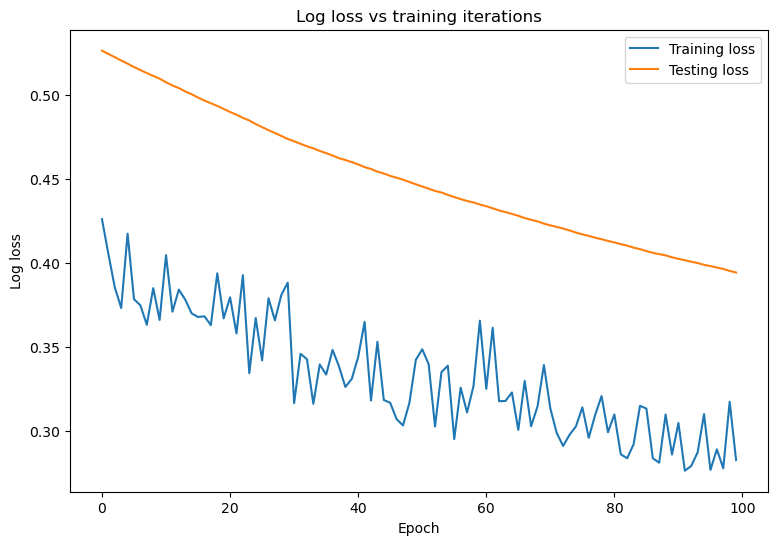

In [41]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");
plt.show()

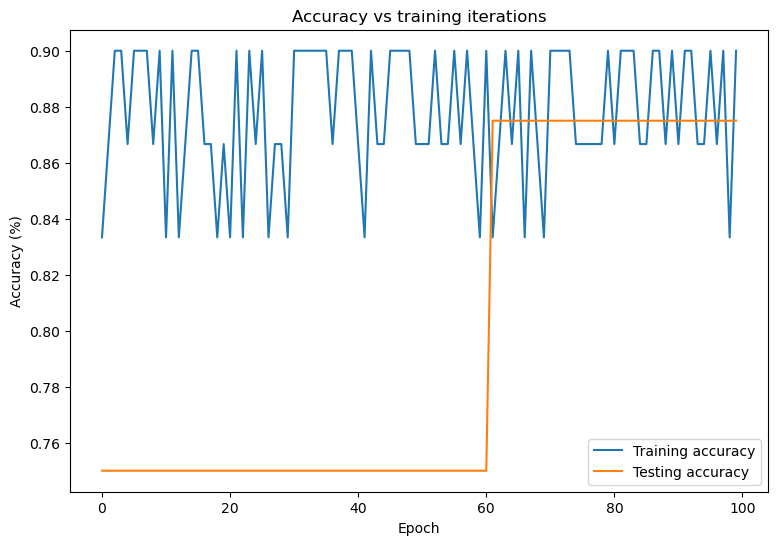

In [42]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");
plt.show()

In [43]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.283
Final testing log Loss: 0.395


In [44]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.900
Final testing accuracy: 0.875


In [45]:
print("real test", accuracy(log_reg(x_val_norm), y_val))
print(log_reg(x_val_norm))
print(y_val)

real test tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(
[ 0.9963346  -1.1931113   0.9370658   1.0078549  -0.63008964 -0.49968657
  2.900372   -4.9556     -0.82702065], shape=(9,), dtype=float32)
tf.Tensor([1. 0. 1. 1. 0. 0. 1. 0. 0.], shape=(9,), dtype=float32)


In [46]:
def show_confusion_matrix(y, y_classes, typ):
    # Compute the confusion matrix and normalize it
    plt.figure(figsize=(10,10))
    confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1)
    axis_labels = range(2)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title(f"Confusion matrix: {typ}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

y_pred_train, y_pred_test, y_pred_val = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False), log_reg(x_val_norm, train=False)
train_classes, test_classes, val_classes = predict_class(y_pred_train), predict_class(y_pred_test), predict_class(y_pred_val)

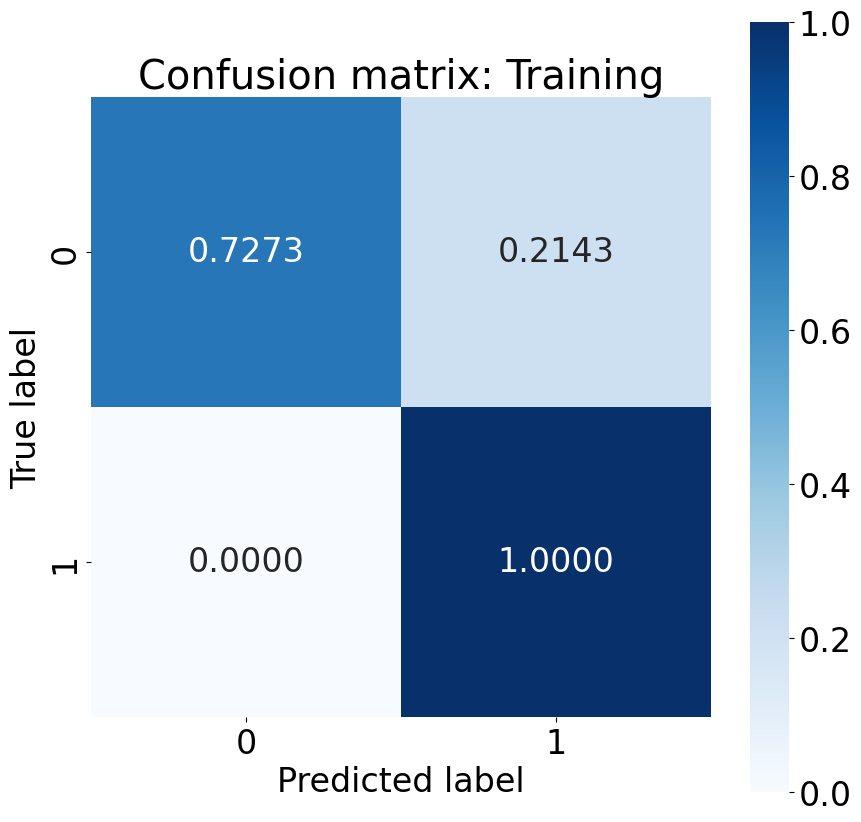

In [47]:
plt.rcParams.update({'font.size': 24})

show_confusion_matrix(y_train, train_classes, 'Training')
plt.show()

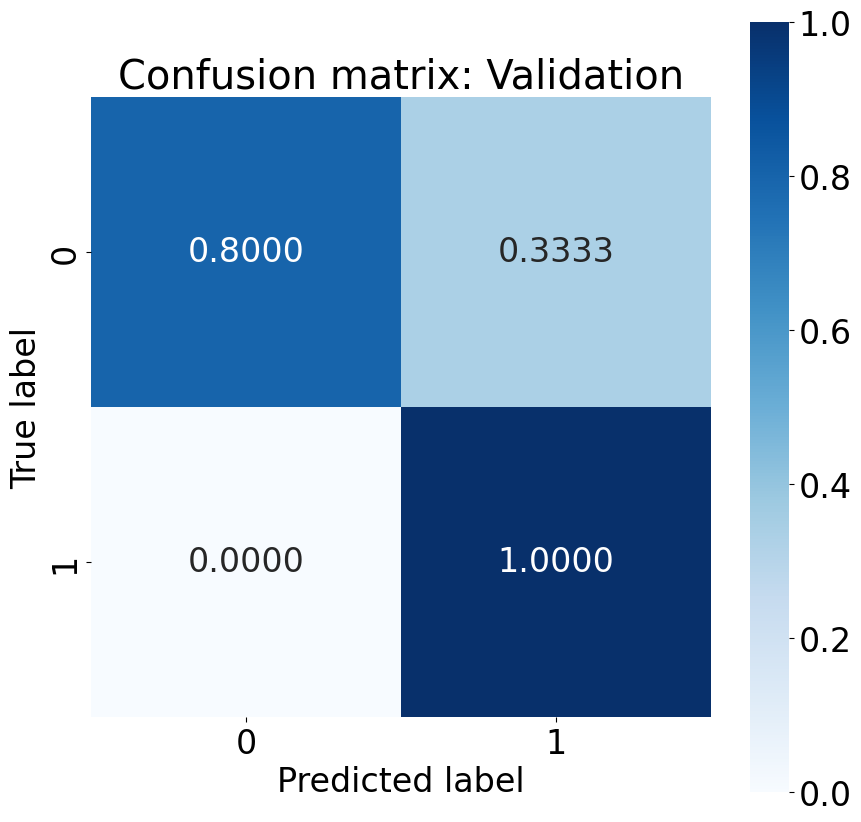

In [48]:
# Testing and validation have been labeled the other way around 
show_confusion_matrix(y_test, test_classes, 'Validation')
plt.show()

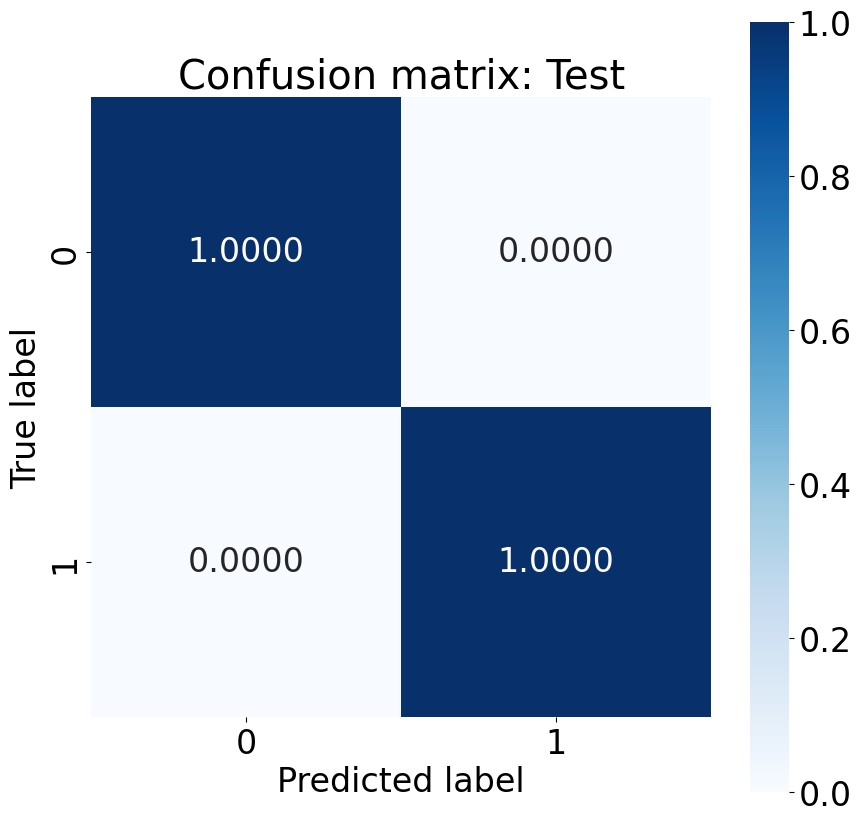

In [49]:
show_confusion_matrix(y_val, val_classes, "Test")
plt.show()

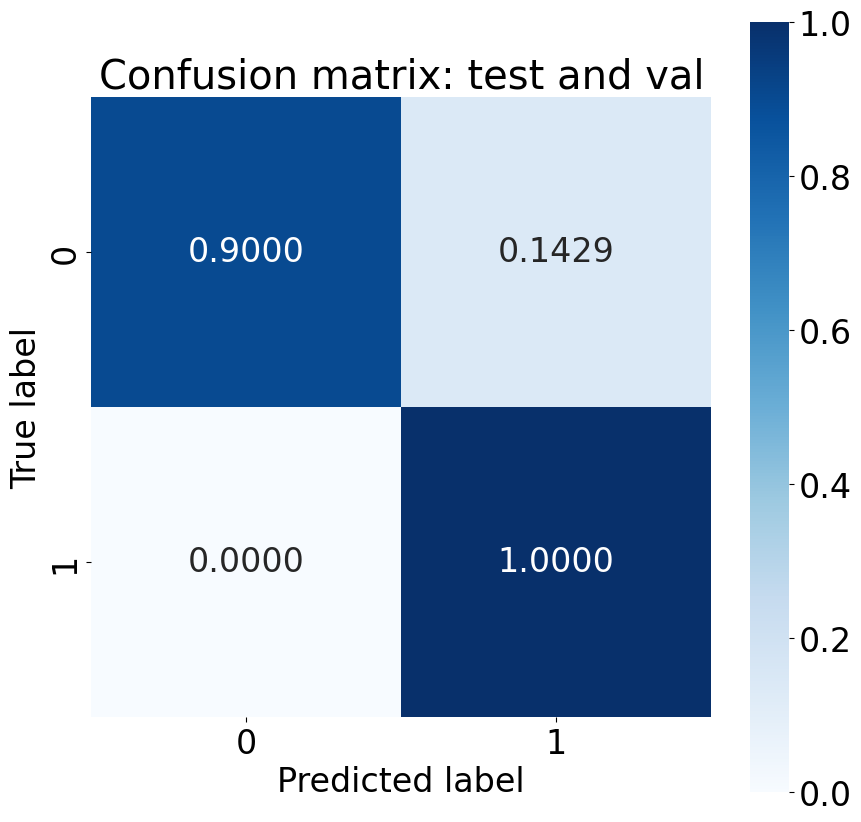

In [50]:
show_confusion_matrix(tf.concat([y_test, y_val], axis=0), tf.concat([test_classes, val_classes],axis=0), "test and val")
plt.show()